## Molecular Cross-Validation

In this notebook we demonstrate how to use molecular cross-validation to calibrate an arbitary denoising method.

In [1]:
import csv
import gzip

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd

import scanpy as sc

from molecular_cross_validation.mcv_sweep import GridSearchMCV

We use data from _Paul, Arkin, Giladi et al._. Download from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72857) and place in `data/myeloid`.

In [2]:
# read in metadata file to get sample annotations
with gzip.open("../data/myeloid/GSE72857_experimental_design.txt.gz", "rt") as f:
    rdr = csv.reader(f, delimiter='\t')
    row = next(rdr)
    for row in rdr:
        if row[0] == "Well_ID" and row[1] == "Seq_batch_ID":
            break

    rows = list(csv.DictReader(f, fieldnames=row, delimiter="\t"))
    
# read in text file as AnnData object
with gzip.open("../data/myeloid/GSE72857_umitab.txt.gz", "rt") as f:
    myeloid_ad = sc.read_text(f, delimiter="\t", first_column_names=True).T

# filter to myeloid samples
myeloid_ids = [
    r["Well_ID"] for r in rows if r["Batch_desc"] == "Unsorted myeloid"
]
myeloid_ad = myeloid_ad[myeloid_ids, :]

# filter to ≥1000 UMIs per cell and ≥10 cells per gene
sc.pp.filter_cells(myeloid_ad, min_counts=1000)
sc.pp.filter_genes(myeloid_ad, min_cells=10)

umis = np.asarray(myeloid_ad.X.astype(int))

Trying to set attribute `.obs` of view, making a copy.


### Defining a denoiser

A denoiser is just a function that takes an `numpy.ndarray` of UMIs and returns a denoised version. This function can take any form as long as the returned array is of the same shape and scale as the original data. Parameters for the denoiser are passed in as keyword arguments and will be calibrated by grid search using the MCV loss.

In this example, we define a simple denoiser based on graph diffusion. (This corresponds to the second column of Figure 1c from the paper.) We construct a knn graph based on a PCA-projected version of the normalized data, then apply a diffusion based on that graph to the raw count data.

In [3]:
# Helper function for the diffusion denoiser, computes the diffusion operator
# as a lazy walk over a k-nearest-neighbors graph of the data in PC space.
def compute_diff_op(
    umis: np.ndarray,
    n_components: int = 30,
    n_neighbors: int = 15,
    tr_prob: float = 0.5,
):
    n_counts = np.median(umis.sum(axis=1))

    x1_norm = np.sqrt(umis / umis.sum(axis=1, keepdims=True) * n_counts)

    U, S, V = randomized_svd(x1_norm, n_components)

    p = U.dot(np.diag(S))

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(p)

    diff_op = np.array(nbrs.kneighbors_graph(p, mode="connectivity").todense())
    diff_op += diff_op.T
    diff_op = diff_op / diff_op.sum(axis=1, keepdims=True)
    diff_op = tr_prob * diff_op + (1 - tr_prob) * np.eye(diff_op.shape[0])

    return diff_op


# Diffuse gene values using a lazy walk over a kNN graph. First,
# calculates a kNN graph in PC space and uses that to define a diffusion
# operator. Next, iteratively smoothes the input data according to the
# operator, and returns the result.
def gene_diffusion(umis: np.ndarray, time_steps: int, **diff_op_kwargs):
    # calculate the diffusion operator, e.g. a weighting over a kNN graph
    diff_op = compute_diff_op(umis, **diff_op_kwargs)
    diffused_umis = umis.copy().astype(np.float)

    # perform diffusion over the knn graph
    for t in range(time_steps):
        diffused_umis = diff_op.dot(diffused_umis)

    return diffused_umis

### Running an MCV grid search

The `GridSearchMCV` class searches over a parameter grid for a given denoiser. The interface is inspired by scikit-learn's GridSearchCV, but it is slightly different due to the nature of the MCV process.

Additional options at initialization are:
  
 - `data_split` : Proportion of UMIs to use for denoising (default 0.9).
 - `sample_ratio` : Estimated ratio of counts in the sample compared to the original cells.
 - `n_splits` : Number of times to split UMIs for a given parameterization.
 - `loss` : either `mse` or `poisson`.
 - `transformation` : Transformation to apply to count matrix before denoising. Either `None`, `'sqrt'`, or an arbitrary function. If a function is used, `data_split` must be 0.5.
 -  `random_state` : If int, random_state is the seed used by the random number generator. If RandomState instance, random_state is the random number generator. If None, the random number generator is the RandomState instance used by `np.random`.

The `fit` method will split the original data into two parts, $X^{\prime}$ and $X^{\prime\prime}$, according to the parameter `data_split`. For each combination of parameters, the denoiser will be applied to $X^{\prime}$ and evaluated on $X^{\prime\prime}$, and the resulting MCV loss will be recorded. After `fit` has been called, the `best_params_` attribute will contain the parameters that yielded the best MCV loss, and the loss itself will be in `best_loss_`. The `cv_results_` attribute will contain the results for all of the tested parameters.

In concordance with the scikit-learn interface, `transform` applies the model selected by MCV to the input data, and `fit_transform` sequentially fits the model and transforms the data.

In [4]:
mcv_search = GridSearchMCV(
    gene_diffusion,
    data_split=0.9,
    n_splits=1, 
    loss="poisson",
    param_grid={"time_steps": np.arange(3, 11), "n_components": [10, 20, 30, 40]}
)

denoised_umis = mcv_search.fit_transform(umis)

After running the MCV parameter search, we can plot the results and identify the optimal parameter settings, shown below.

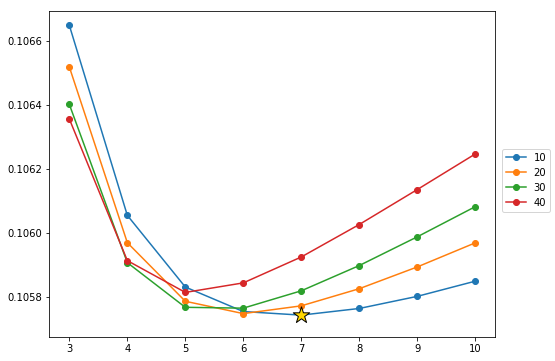

In [5]:
mcv_df = pd.DataFrame(mcv_search.cv_results_)

fig,ax = plt.subplots(1, 1, figsize=(8,6))

mcv_arr = mcv_df["mcv_loss"].values.reshape((8, 4), order="F")
line_obj = ax.plot(np.arange(3, 11), mcv_arr, marker="o")

# mark the optimal value
ax.scatter(
    [3 + mcv_arr.min(1).argmin()], [mcv_arr.min(1).min()], 
    marker="*", linewidths=1, edgecolor="k", s=300, c="gold", zorder=3
)

plt.figlegend(iter(line_obj), ('10', '20', '30', '40'), loc=7)
plt.show()

We also plot the expression of _Apoe_ and _Gata1_ as in Figure 2b. We observe the same qualitative relationship that was revealed in that figure MCV-calibrated PCA.

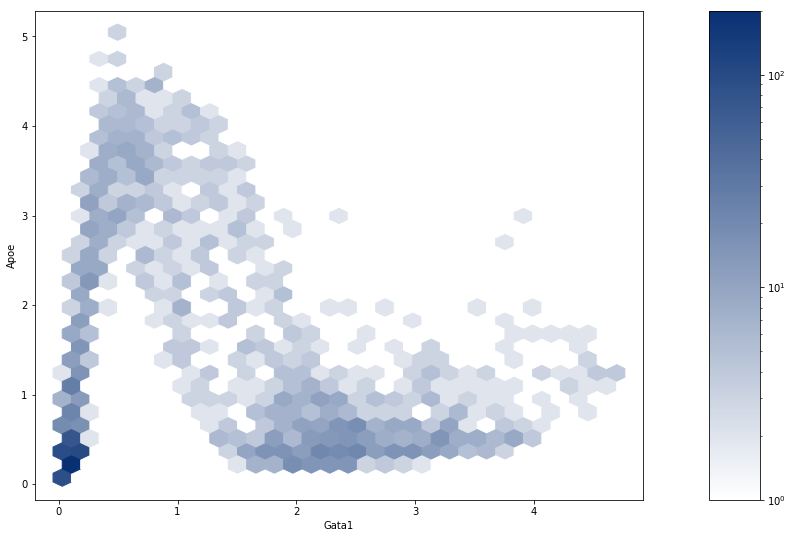

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(13,9), gridspec_kw={"width_ratios": [12,1]})

# version of 'Blues' colormap that is pure white at the bottom
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "BluesW",
    [(1.0, 1.0, 1.0), (0.0314, 0.188, 0.450)]
)

m = ax[0].hexbin(
    denoised_umis[:, myeloid_ad.var.index.get_loc("Gata1")],
    denoised_umis[:, myeloid_ad.var.index.get_loc("Apoe")],
    gridsize=30,
    bins='log',
    cmap=cmap,
    vmin=1,
    vmax=200,
)

ax[0].set_xlabel("Gata1")
ax[0].set_ylabel("Apoe")

plt.colorbar(m, cax=ax[1])
plt.show()